# NOAA Workshop - Rainfall Skill Explorer
**Training Guide for KMD, UNMA, and Meteo Rwanda**

**Workshop Title:** Rainfall Product Skill Assessment & Flood Case Studies
**Duration:** ~2 hours (hands-on session)
**Notebook:** `NOAA_Rainfall_Skill_Explorer_v2.ipynb`

## 1. Workshop Objectives

By completing this exercise, you will:
* Learn how to use the Rainfall Skill Explorer Jupyter Notebook to evaluate multiple rainfall products.
* Assess the skill, bias, and reliability of CHIRPS, TAMSAT, IMERG, and ERA5 against validated ground stations.
* Explore long-term rainfall trends (2014-2024) in your country's capital.
* Analyze how each dataset captured severe flood events in Kenya, Uganda, and Rwanda.
* Discuss operational implications for early warning, forecasting, and product selection.

## 2. Dataset Overview

| Category | Dataset | Source | Spatial Resolution | Temporal Coverage | Notes |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Ground Observations** | TAHMO / National Met Stations | Met agencies | Point | Daily | High-confidence QC from Notebook 1 |
| **Satellite Products** | CHIRPS | UCSB/ FEWS NET | $0.05^{\circ}$ (~5 km) | 1981-present | May underestimate convective extremes |
| | TAMSAT | University of Reading | 0.0375° (~4 km) | 1983-present | Strong climatology, may miss isolated storms |
| | IMERG (GPM) | NASA | 0.1° (~10 km) | 2000-present | Good detection of extremes, higher variance |
| **Reanalysis** | ERA5 | ECMWF | 0.25° (~25 km) | 1979-present | Smooth but underestimates short bursts |

## 3. Notebook Workflow Overview

### Step 1- Setup & Configuration
Open the notebook and review the `CONFIG` cell.
Confirm:
* Your country (Kenya, Uganda, or Rwanda)
* Data paths for ground and satellite files
* Output folder (default: `Results_SkillExplorer_<country>_<date>`)

Run all cells from the top: `File > Trust Notebook > Runtime > Restart & Run All`.

### Step 2- Load Data
The notebook will:
* Load your high-confidence ground stations.
* Load the four rainfall products (NetCDF files).
* Confirm the number of ground data rows in range.
If a file is missing, the notebook will skip that dataset and continue.

### Step 3- Controls & Country Selection
Use the widget panel to:
* Select your country.
* Choose a station (high-confidence).
* Pick the datasets to compare (e.g., CHIRPS, TAMSAT, IMERG, ERA5).
* Choose extreme rainfall thresholds (e.g., 20, 50, 100 mm).
* Select a case study event (Kenya, Uganda, or Rwanda).

## 4. Case Study Contexts

### Kenya – Mai Mahiu Flash Flood (Nakuru County)
* **Date:** 29 April 2024
* **Window:** 20 April - 5 May 2024
* Intense rainfall caused a culvert and railway embankment failure near Mai Mahiu. This led to 61 deaths, 109 hospitalizations, and dozens missing.
* The floods occurred after weeks of heavy rain, which compounded soil saturation and runoff.
* **Objective:** Evaluate how rainfall products captured the accumulation and intensity leading up to the flood.

### Uganda - Mbale-Kapchorwa Floods (Eastern Region)
* **Date:** 30 July 2022
* **Window:** 28 July - 2 August 2022
* Rivers Nabuyonga and Namatala overflowed after 3-5 days of intense rain, affecting Mbale, Kapchorwa, Sironko, Bulambuli, and Bukedea.
* The event resulted in 24-29 fatalities and impacted over 3,700 households.
* **Objective:** Compare how rainfall datasets capture short-duration, high-intensity rainfall bursts.

### Rwanda – Western & Northern Provinces Floods
* **Date:** 2 May 2023
* **Window:** 1 May - 8 May 2023
* Nighttime cloudbursts caused flash floods and landslides in Ngororero, Rubavu, Rutsiro, and Nyabihu.
* There were over 130 deaths, 5,000 homes destroyed, and 10,000 households displaced. The event was linked to strong convective systems along the Congo Air Boundary.
* **Objective:** Assess whether global models (ERA5, IMERG) or regionally tuned products (TAMSAT, CHIRPS) detect spatially localized storms.

## 5. Guided Notebook Steps


## 6. Wrap-Up: Compare Across Countries

Once each national team completes their case (Kenya: Mai Mahiu; Uganda: Mbale-Kapchorwa; Rwanda: Western/Northern floods), facilitators will lead a cross-country comparison discussion.

## 7. Expected Deliverables
Each team should produce PNG figures and CSV outputs, which will be saved in the `Results_SkillExplorer_<country>_<date>` folder.

## 8. Interpretation Template (for group reporting)

| Country | Station / Event | Best Performing Product | Main Finding | Operational Implication |
| :--- | :--- | :--- | :--- | :--- |
| **Kenya** | KE-012 Mai Mahiu (2024) | IMERG | Best extreme detection; CHIRPS underestimates | Combine IMERG for flood alerting + ERA5 for background context |
| **Uganda** | UG-00456 Mbale-Kapchorwa (2022) | ERA5 | Consistent timing; TAMSAT misses short bursts | ERA5 captures system-scale but misses extremes |
| **Rwanda** | RW-00789 Western Floods (2023) | TAMSAT | Good match to ground totals; ERA5 underestimates | Regional bias correction could improve early warnings |



**Audience:** KMD, UNMA, Meteo Rwanda  
**Tip:** File → Trust → Runtime → Restart & run all.

In [2]:
# @title Setting up environment installing required Dependencies
# @markdown This cell installs the required dependencies for the workshop. It may take a few minutes <br>
# @markdown If you encounter any errors, please restart the runtime and try again. <br>
# @markdown If the error persists, please seek help.


print("Installing required dependencies...")
!pip install git+https://github.com/kaburia/NOAA-workshop.git > /dev/null 2>&1
!pip install scipy --upgrade > /dev/null 2>&1 # Added to upgrade scipy

!jupyter nbextension enable --py widgetsnbextension

# check there was no error
import sys
if not sys.argv[0].endswith("kernel_launcher.py"):
    print("❌ Errors occurred during installation. Please restart the runtime and try again.")
else:
    print("✅ Dependencies installed successfully.")

print("Importing required libraries...")
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, ttest_rel

# import os
# os.chdir('NOAA-workshop')

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.plotting import plot_xarray_data, plot_xarray_data2
from google.colab import drive

%matplotlib inline

print("✅ Libraries imported successfully.")

Installing required dependencies...
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
✅ Dependencies installed successfully.
Importing required libraries...
✅ Libraries imported successfully.


In [13]:
# 1) CONFIG
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as W
from IPython.display import display, clear_output
import os, numpy as np, pandas as pd
from datetime import date

from google.colab import drive
drive.mount('/content/drive')

try:
    import geopandas as gpd
    import contextily as cx
    from matplotlib.lines import Line2D
    from matplotlib.cm import ScalarMappable
    print("✅ Geospatial and plotting libraries loaded.")
except ImportError:
    print("❌ WARNING: Geospatial libraries not found. Please run '!pip install geopandas contextily' in a code cell.")
    gpd, cx, Line2D, ScalarMappable = None, None, None, None

# 1) DATA LOADING
DRIVE_PATH = '/content/drive/Shareddrives/NOAA-workshop/Datasets/'
CAPITALS={'Kenya':{'name':'Nairobi','lat':-1.2921,'lon':36.8219},
          'Uganda':{'name':'Kampala','lat':0.3476,'lon':32.5825},
          'Rwanda':{'name':'Kigali','lat':-1.9579,'lon':30.1127}}



COUNTRY='Kenya'
GROUND_CSV='./ground_daily_high_confidence.csv'; CHIRPS_NC='./CHIRPS_daily.nc'; TAMSAT_NC='./TAMSAT_daily.nc'; IMERG_NC='./IMERG_daily.nc'; ERA5_NC='./ERA5_daily.nc'
START_DATE='2014-01-01'; END_DATE=date.today().isoformat(); LTN_BASE=('2014-01-01','2024-12-31')
NEIGHBORHOOD=1; EXTREME_THRESHOLDS=[20,50,100]; CORR_METHOD='pearson'
EVENTS={'Kenya – Mai Mahiu flash flood (2024-04-29)':('2024-04-20','2024-05-05'),
        'Uganda – Mbale–Kapchorwa floods (2022-07-30)':('2022-07-28','2022-08-02'),
        'Rwanda – Western/Northern floods (2023-05-02)':('2023-05-01','2023-05-08')}

RUN_STAMP=date.today().isoformat(); RESULTS_DIR=f'./Results_SkillExplorer_{COUNTRY}_{RUN_STAMP}'; os.makedirs(RESULTS_DIR, exist_ok=True); np.random.seed(42)
print('✅ CONFIG set →', RESULTS_DIR)


print("Loading datasets...")
try:
    # TAHMO Ground truth
    df_gt_kenya = pd.read_csv(os.path.join(DRIVE_PATH, 'tahmo_precip_2024-04-20_2024-05-05_Kenya.csv.csv'))
    df_gt_uganda = pd.read_csv(os.path.join(DRIVE_PATH, 'tahmo_precip_2022-07-28_2022-08-02_Uganda.csv.csv'))
    df_gt_rwanda = pd.read_csv(os.path.join(DRIVE_PATH, 'tahmo_precip_2023-05-01_2023-05-08_Rwanda.csv.csv'))
    # station scores


    # Satellite Products
    # CHIRPS
    ds_chirps_kenya = xr.open_dataset(os.path.join(DRIVE_PATH, 'CHIRPS_2024-04-20_2024-05-05_Kenya.nc'))
    ds_chirps_uganda = xr.open_dataset(os.path.join(DRIVE_PATH, 'CHIRPS_2022-07-28_2022-08-02_Uganda.nc'))
    ds_chirps_rwanda = xr.open_dataset(os.path.join(DRIVE_PATH, 'CHIRPS_2023-05-01_2023-05-08_Rwanda.nc'))

    # TAMSAT
    ds_tamsat_kenya = xr.open_dataset(os.path.join(DRIVE_PATH, 'TAMSAT_precip_2024-04-20_2024-05-05_Kenya.nc'))
    ds_tamsat_uganda = xr.open_dataset(os.path.join(DRIVE_PATH, 'TAMSAT_precip_2022-07-28_2022-08-02_Uganda.nc'))
    ds_tamsat_rwanda = xr.open_dataset(os.path.join(DRIVE_PATH, 'TAMSAT_precip_2023-05-01_2023-05-08_Rwanda.nc'))

    # IMERG
    ds_imerg_ke = xr.open_dataset(os.path.join(DRIVE_PATH, 'IMERG_2024-04-20_2024-05-05_Kenya.nc')).resample(time='D').sum()
    ds_imerg_ug = xr.open_dataset(os.path.join(DRIVE_PATH, 'IMERG_2022-07-28_2022-08-02_Uganda.nc')).resample(time='D').sum()
    ds_imerg_rw = xr.open_dataset(os.path.join(DRIVE_PATH, 'IMERG_2023-05-01_2023-05-08_Rwanda.nc')).resample(time='D').sum()

    # ERA5
    ds_era5_kenya = xr.open_dataset(os.path.join(DRIVE_PATH, 'ERA5_precip_2024-04-20_2024-05-05_Kenya.nc'))
    ds_era5_uganda = xr.open_dataset(os.path.join(DRIVE_PATH, 'ERA5_precip_2022-07-28_2022-08-02_Uganda.nc'))
    ds_era5_rwanda = xr.open_dataset(os.path.join(DRIVE_PATH, 'ERA5_precip_2023-05-01_2023-05-08_Rwanda.nc'))
    print("✅ All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ ERROR: Data file not found. Please check your DRIVE_PATH and file names. Details: {e}")
    # Create empty placeholders to avoid further errors
    df_gt_kenya, df_gt_uganda, df_gt_rwanda = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    ds_chirps_kenya, ds_chirps_uganda, ds_chirps_rwanda, ds_tamsat_kenya, ds_tamsat_uganda, ds_tamsat_rwanda, ds_imerg_ke, ds_imerg_ug, ds_imerg_rw, ds_era5_kenya, ds_era5_uganda, ds_era5_rwanda = [None]*12

# 2) HELPER FUNCTIONS & SETUP
print("Defining helper functions and setting up metadata...")

def preprocess_df_gt(df_gt):
    if df_gt.empty: return df_gt
    df_gt.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    df_gt['Date'] = pd.to_datetime(df_gt['Date'])
    df_gt.set_index('Date', inplace=True)
    if df_gt.index.tz is not None: df_gt.index = df_gt.index.tz_localize(None)
    return df_gt

df_gt_kenya, df_gt_uganda, df_gt_rwanda = map(preprocess_df_gt, [df_gt_kenya, df_gt_uganda, df_gt_rwanda])

def rename_coords(ds):
    if ds is None: return None
    return ds.rename({'lat': 'y', 'lon': 'x'}) if 'lat' in ds.coords and 'lon' in ds.coords else ds

ds_tamsat_kenya, ds_tamsat_uganda, ds_tamsat_rwanda = map(rename_coords, [ds_tamsat_kenya, ds_tamsat_uganda, ds_tamsat_rwanda])
ds_era5_kenya, ds_era5_uganda, ds_era5_rwanda = map(rename_coords, [ds_era5_kenya, ds_era5_uganda, ds_era5_rwanda])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Geospatial and plotting libraries loaded.
✅ CONFIG set → ./Results_SkillExplorer_Kenya_2025-10-14
Loading datasets...
✅ All datasets loaded successfully.
Defining helper functions and setting up metadata...


In [4]:
# upload config files
from google.colab import files
uploaded = files.upload()

Saving config.json to config.json


In [5]:
from utils.filter_stations import RetrieveData
import json

with open('config.json') as f:
    config = json.load(f)

api_key = config['apiKey']
api_secret = config['apiSecret']

# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)
tahmo_metadata = rd.get_stations_info()

# rename location.latitude to y and location.longitude to x
tahmo_metadata = tahmo_metadata.rename({'location.latitude': 'y', 'location.longitude': 'x'})
# # save the metadata to drive path
# tahmo_metadata.to_csv(os.path.join(DRIVE_PATH, 'tahmo_metadata.csv'))

In [6]:
# 2) HELPERS
import numpy as np, pandas as pd, os
def load_ground(p):
    if not os.path.exists(p): print('⚠️ Ground CSV not found:', p); return None
    df=pd.read_csv(p,parse_dates=['date']); req={'station_id','date','precip','lat','lon'}; miss=req-set(df.columns)
    if miss: print('⚠️ Missing cols:',miss); return None
    if 'high_confidence' in df.columns: df=df[df['high_confidence']==True].copy()
    return df
def open_nc(p):
    try:
        import xarray as xr
        return xr.open_dataset(p) if os.path.exists(p) else None
    except Exception as e: print('ℹ️ xarray error:', e); return None

def _near(arr,val):
    arr=np.asarray(arr); return int(np.argmin(np.abs(arr-val)))

def extract_timeseries(ds,lat,lon,k=1):
    if ds is None: return None
    import pandas as pd
    var=list(ds.data_vars)[0] if ds.data_vars else None
    if var is None: return None

    # Assume dimensions are 'y' and 'x' after renaming
    lat_dim, lon_dim = 'y', 'x'

    if lat_dim not in ds.dims or lon_dim not in ds.dims:
         raise ValueError(f"Dataset does not contain expected dimensions '{lat_dim}' and '{lon_dim}'. Found: {list(ds.dims)}")

    lats=ds[lat_dim].values; lons=ds[lon_dim].values
    lon_w=lon if not(lons.min()>=0 and lons.max()>180 and lon<0) else lon%360.0
    i=_near(lats,lat); j=_near(lons,lon_w)
    sub=ds[var].isel({lat_dim: i, lon_dim: j}) if k==1 else ds[var].isel({lat_dim: slice(max(i-k//2,0),i+k//2+1), lon_dim: slice(max(j-k//2,0),j+k//2+1)}).mean(dim=[lat_dim,lon_dim],skipna=True)
    try: ts=sub.to_series()
    except Exception: ts=pd.Series(sub.values,index=pd.to_datetime(ds['time'].values))
    if ts.dropna().quantile(0.99)<1.0: ts=ts*1000.0
    return ts

def monthly_sum(ts):
    return None if ts is None or ts.empty else ts.resample('MS').sum(min_count=1)
def mann_kendall(ms):
    s=ms.dropna().values; n=len(s)
    if n<8: return {'slope':np.nan,'p':np.nan,'direction':'insufficient'}
    S=0
    for i in range(n-1): S+=np.sum(np.sign(s[i+1:]-s[i]))
    varS=(n*(n-1)*(2*n+5))/18.0
    z=(S-1)/np.sqrt(varS) if S>0 else ((S+1)/np.sqrt(varS) if S<0 else 0.0)
    from math import erf, sqrt; Phi=lambda z:0.5*(1.0+erf(z/np.sqrt(2.0))); p=2*(1-Phi(abs(z)))
    x=np.arange(n); slopes=[]
    for i in range(n-1): dx=(x[i+1:]-x[i]); dy=(s[i+1:]-s[i]); slopes+=list(dy/dx)
    slope=float(np.median(slopes)); direction='increasing' if slope>0 and p<0.05 else ('decreasing' if slope<0 and p<0.05 else 'no_significant_trend')
    return {'slope':slope,'p':float(p),'direction':direction}
def metrics(gt,mod,ths):
    # Ensure both Series have timezone information and are in UTC
    if gt.index.tzinfo is None:
        gt = gt.tz_localize('UTC')
    else:
        gt = gt.tz_convert('UTC')

    if mod.index.tzinfo is None:
        mod = mod.tz_localize('UTC')
    else:
        mod = mod.tz_convert('UTC')

    df=pd.concat([gt.rename('gt'),mod.rename('mod')],axis=1).dropna()
    if df.empty: return None
    rmse=float(np.sqrt(((df['mod']-df['gt'])**2).mean())); bias=float((df['mod']-df['gt']).abs().mean())
    cp=df.corr(method='pearson').iloc[0,1]; cs=df.corr(method='spearman').iloc[0,1]
    hits={}
    for th in ths:
        gt_hit=df['gt']>=th; mod_hit=df['mod']>=th; denom=int(gt_hit.sum()); hits[f'hitrate_{th}mm']=float((gt_hit&mod_hit).sum()/denom) if denom>0 else np.nan
    return {'rmse':rmse,'bias':bias,'corr_pearson':float(cp),'corr_spearman':float(cs),**hits}

### Step 4 Widgets to choose country and product

In [9]:
# 4) WIDGETS
import ipywidgets as W
from IPython.display import display
COUNTRY = 'Kenya'


CAPITALS={'Kenya':{'name':'Nairobi','lat':-1.2921,'lon':36.8219},
          'Uganda':{'name':'Kampala','lat':0.3476,'lon':32.5825},
          'Rwanda':{'name':'Kigali','lat':-1.9579,'lon':30.1127}}

country_w=W.Dropdown(options=['Kenya','Uganda','Rwanda'],value=COUNTRY,description='Country:')

cap=CAPITALS[country_w.value]
series={}

EVENTS_dict={'Kenya': ('2024-04-20','2024-05-05'),
        'Uganda': ('2022-07-28','2022-08-02'),
        'Rwanda': ('2023-05-01','2023-05-08')
        }

# get the START and End date depending on country

START_DATE, END_DATE = EVENTS_dict[country_w.value]
LTN_BASE = (START_DATE, END_DATE)

NEIGHBORHOOD=1; EXTREME_THRESHOLDS=[20,50,100]; CORR_METHOD='pearson'

RESULTS_DIR=f'/content/drive/Shareddrives/NOAA-workshop/Datasets/Results_SkillExplorer_{COUNTRY}'; os.makedirs(RESULTS_DIR, exist_ok=True);


country_w=W.Dropdown(options=['Kenya','Uganda','Rwanda'],value=COUNTRY,description='Country:')
# try to see if the confidence for that stations were evaluated
try:
  station_scores = pd.read_csv(os.path.join(DRIVE_PATH, f'station_scores_{country_w.value.upper()}.csv'))
  print('✅ Confidence scores loaded successfully')
except:
  print('❌ Confidence scores not found, Please run the focus 1 notebook first')
  station_scores = None

# depending on country choose the datasets
if country_w.value == 'Kenya':
  df_gt=df_gt_kenya
  ds_chirps=ds_chirps_kenya
  ds_tamsat=ds_tamsat_kenya
  ds_imerg=ds_imerg_ke
  ds_era5=ds_era5_kenya
  # read the station scores


elif country_w.value == 'Uganda':
  df_gt=df_gt_uganda
  ds_chirps=ds_chirps_uganda
  ds_tamsat=ds_tamsat_uganda
  ds_era5=ds_era5_uganda
  ds_imerg=ds_imerg_ug

elif country_w.value == 'Rwanda':
  df_gt=df_gt_rwanda
  ds_chirps=ds_chirps_rwanda
  ds_tamsat=ds_tamsat_rwanda
  ds_era5=ds_era5_rwanda
  ds_imerg=ds_imerg_rw

# Apply rename_coords to ensure consistent coordinate names
ds_tamsat, ds_imerg, ds_era5 = map(rename_coords, [ds_tamsat, ds_imerg, ds_era5])

stations=sorted(df_gt.columns.tolist()) if df_gt is not None and not df_gt.empty else []
station_w=W.Dropdown(options=stations,description='Station:')

EVENTS={'Kenya – Mai Mahiu flash flood (2024-04-29)':('2024-04-20','2024-05-05'),
        'Uganda – Mbale–Kapchorwa floods (2022-07-30)':('2022-07-28','2022-08-02'),
        'Rwanda – Western/Northern floods (2023-05-02)':('2023-05-01','2023-05-08')}

dataset_w=W.SelectMultiple(options=['CHIRPS','TAMSAT','IMERG','ERA5'],value=('CHIRPS','TAMSAT','IMERG','ERA5'),description='Datasets:')
thresh_w=W.SelectMultiple(options=[20,50,100],value=(20,50,100),description='≥ Thresholds:')
event_w=W.Dropdown(options=list(EVENTS.keys()),value=list(EVENTS.keys())[0],description='Case study:')
display(country_w,
        dataset_w,
        thresh_w,
        event_w); print('✅ Controls ready')

Dropdown(description='Country:', options=('Kenya', 'Uganda', 'Rwanda'), value='Kenya')

SelectMultiple(description='Datasets:', index=(0, 1, 2, 3), options=('CHIRPS', 'TAMSAT', 'IMERG', 'ERA5'), val…

SelectMultiple(description='≥ Thresholds:', index=(0, 1, 2), options=(20, 50, 100), value=(20, 50, 100))

Dropdown(description='Case study:', options=('Kenya – Mai Mahiu flash flood (2024-04-29)', 'Uganda – Mbale–Kap…

✅ Controls ready



### Step 5- LTN & Trends (Capital Overlay)
**Goal:** Examine 2014-2024 rainfall patterns for your capital city.
This section extracts monthly totals for ERA5, TAMSAT, and IMERG and plots monthly totals over time, monthly climatology, and computes a Mann-Kendall trend test.

**Interpretation Questions:**
1.  Do all products show the same seasonal cycle (bimodal vs unimodal)?
2.  Is there a trend (increasing or decreasing rainfall)?
3.  Which product shows the largest interannual variability?
4.  How might these differences influence early-season advisories?

In [17]:
cap

{'name': 'Nairobi', 'lat': -1.2921, 'lon': 36.8219}

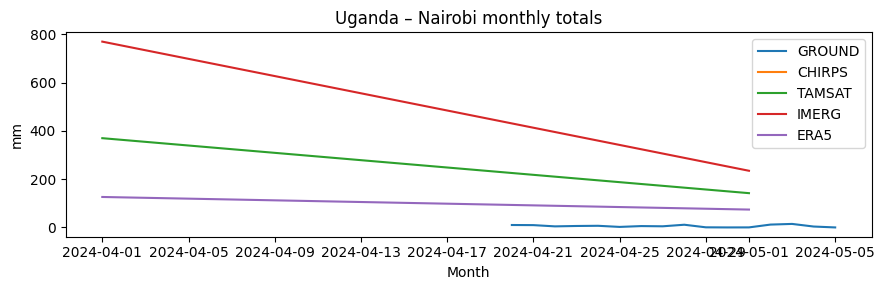

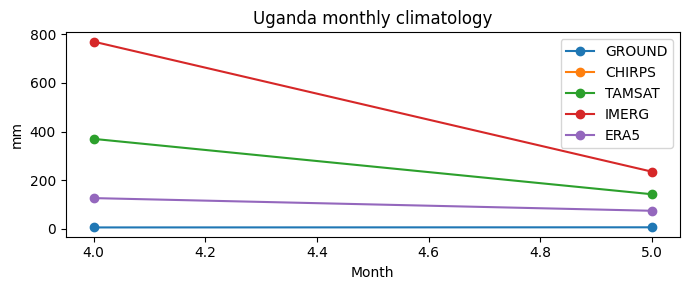

,dataset,slope,p,direction
0,GROUND,-0.424575,0.207442,no_significant_trend
1,CHIRPS,NaN,NaN,insufficient
2,TAMSAT,NaN,NaN,insufficient
3,IMERG,NaN,NaN,insufficient
4,ERA5,NaN,NaN,insufficient


- GROUND: slope=-0.42 mm/mon, p=0.207, trend=no_significant_trend
- CHIRPS: slope=nan mm/mon, p=nan, trend=insufficient
- TAMSAT: slope=nan mm/mon, p=nan, trend=insufficient
- IMERG: slope=nan mm/mon, p=nan, trend=insufficient
- ERA5: slope=nan mm/mon, p=nan, trend=insufficient
✅ LTN exports saved


In [16]:
# 5) LTN & TRENDS
import matplotlib.pyplot as plt, pandas as pd, os


for name,ds in [('ERA5',ds_era5),('TAMSAT',ds_tamsat),('IMERG',ds_imerg)]:
    try:
        ts=extract_timeseries(ds,cap['lat'],cap['lon'],k=NEIGHBORHOOD)
        if ts is None:
            print(f"⚠️ Could not extract time series for {name}. Skipping.")
            continue
        ts=ts[(ts.index>=pd.to_datetime(LTN_BASE[0]))&(ts.index<=pd.to_datetime(LTN_BASE[1]))]
        ms=monthly_sum(ts);
        if ms is not None:
            series[name]=ms
        else:
            print(f"⚠️ Could not compute monthly sum for {name}. Skipping.")
    except Exception as e:
        print(f"❌ Error processing {name}: {e}")


if series:
    fig=plt.figure(figsize=(9,3))

    for n,ms in series.items(): plt.plot(ms.index,ms.values,label=n)
    plt.title(f"{country_w.value} – {cap['name']} monthly totals"); plt.ylabel('mm'); plt.xlabel('Month'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,f"ltn_monthly_{country_w.value}.png")); plt.show()
    clims={n:ms.groupby(ms.index.month).mean() for n,ms in series.items()}
    fig=plt.figure(figsize=(7,3))

    for n,cl in clims.items(): plt.plot(cl.index,cl.values,marker='o',label=n) # Modified to plot against cl.index
    plt.title(f"{country_w.value} monthly climatology"); plt.xlabel('Month'); plt.ylabel('mm'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,f"ltn_climatology_{country_w.value}.png")); plt.show()
    rows=[{'dataset':n,**mann_kendall(ms)} for n,ms in series.items()]; df_trends=pd.DataFrame(rows); display(df_trends)
    df_trends.to_csv(os.path.join(RESULTS_DIR,f"ltn_trends_{country_w.value}.csv"),index=False)

    for _,r in df_trends.iterrows(): print(f"- {r['dataset']}: slope={r['slope']:.2f} mm/mon, p={r['p']:.3f}, trend={r['direction']}")
    print('✅ LTN exports saved')
else:
    print('ℹ️ No LTN series available (check NetCDFs).')


### Step 6- Station Skill vs Ground
**Goal:** Quantify how each rainfall product matches ground truth.
This section plots daily rainfall for the selected station and computes RMSE, bias, Pearson/Spearman correlation, and hit rates to rank the products.

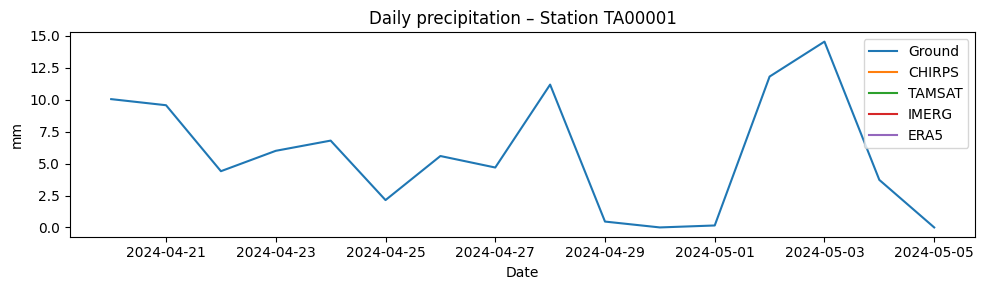

,dataset,rmse,bias,corr_pearson,corr_spearman,hitrate_20mm,hitrate_50mm,hitrate_100mm
0,ERA5,5.112936,4.123609,0.732964,0.747609,NaN,NaN,NaN
1,TAMSAT,6.960539,5.458000,0.381706,0.279009,NaN,NaN,NaN
2,IMERG,22.958524,15.672266,0.514135,0.582143,NaN,NaN,NaN


✅ Station metrics saved


In [15]:
# 6) STATION SKILL
import matplotlib.pyplot as plt, os, pandas as pd, numpy as np

if df_gt is None or df_gt.empty or station_w.value is None: print('⚠️ Select station / load ground.')

else:
    sid=station_w.value
    # Get latitude and longitude from tahmo_metadata for the selected station
    station_metadata_row = tahmo_metadata[tahmo_metadata['code'] == sid]
    if station_metadata_row.empty:
        print(f"⚠️ Metadata not found for station {sid}. Skipping.")
    else:
        lat = float(station_metadata_row['location.latitude'].iloc[0])
        lon = float(station_metadata_row['location.longitude'].iloc[0])


        st=df_gt[sid]
        series={'GROUND': st} # Assign the Series directly


        src={'CHIRPS':ds_chirps,
             'TAMSAT':ds_tamsat,
             'IMERG':ds_imerg,
             'ERA5':ds_era5}

        for d in dataset_w.value:
            ts=extract_timeseries(src.get(d),lat,lon,k=NEIGHBORHOOD)
            if ts is not None:
                # Make product time series timezone-aware and convert to UTC if needed
                if ts.index.tzinfo is None:
                     ts = ts.tz_localize('UTC')
                else:
                     ts = ts.tz_convert('UTC')

                series[d]=ts

        fig=plt.figure(figsize=(10,3)); plt.plot(series['GROUND'].index,series['GROUND'].values,label='Ground')

        for d in dataset_w.value:
            if d in series:
                aligned=series[d].reindex(series['GROUND'].index); plt.plot(aligned.index,aligned.values,label=d)

        plt.title(f"Daily precipitation – Station {sid}"); plt.xlabel('Date'); plt.ylabel('mm'); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR,f"station_ts_{sid}.png")); plt.show()
        rows=[]

        for d in dataset_w.value:
            if d not in series: continue
            met=metrics(series['GROUND'],series[d],thresh_w.value)
            if met: rows.append({'dataset':d,**met})

        if rows:
            dfm=pd.DataFrame(rows).sort_values(['rmse','bias','corr_pearson'],ascending=[True,True,False]).reset_index(drop=True)
            display(dfm); dfm.to_csv(os.path.join(RESULTS_DIR,f"metrics_station_{sid}.csv"),index=False); print('✅ Station metrics saved')

### Step 7 – Case Study Analysis
Select one of the predefined case studies in the dropdown. The "Case Study" section will extract daily rainfall for the event window and plot the daily series.

**Interpretation Guide:**

| Aspect | What to Look For | Example Question |
| :--- | :--- | :--- |
| **Timing** | Did the product detect the start of the rains correctly? | "Did IMERG's peaks align with the Ground rainfall on 28-30 July (Mbale floods)?" |
| **Intensity** | How close were total rainfall amounts to ground totals? | "Did CHIRPS underreport Mai Mahiu totals compared to IMERG or ERA5?" |
| **Duration** | Was the event captured as a multiday or single-day spike? | "Do all datasets show sustained rainfall leading up to the flood?" |
| **Extreme detection** | Which datasets flagged $\ge50mm$ or $\ge100mm$ days? | "Which dataset has highest hit rate for 100mm?" |
| **Operational insight** | Which product could support flood warnings? | "Which dataset would have alerted NMHS staff early?" |

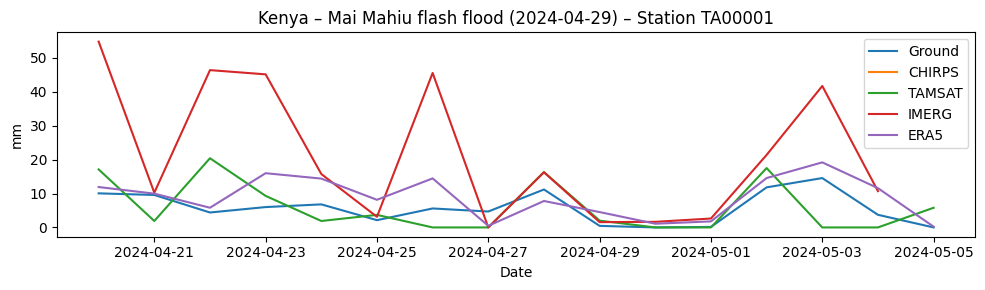

,product,total_mm
0,CHIRPS,0.000000
1,ERA5,141.885879
2,GROUND,91.140000
3,IMERG,316.840027
4,TAMSAT,95.900002


,dataset,rmse,bias,corr_pearson,corr_spearman,hitrate_20mm,hitrate_50mm,hitrate_100mm
0,ERA5,5.112936,4.123609,0.732964,0.747609,NaN,NaN,NaN
1,TAMSAT,6.960539,5.458000,0.381706,0.279009,NaN,NaN,NaN
2,IMERG,22.958524,15.672266,0.514135,0.582143,NaN,NaN,NaN


✅ Case study exports saved


In [12]:
# 7) CASE STUDY
import matplotlib.pyplot as plt, os, pandas as pd, numpy as np
if df_gt is None or df_gt.empty or station_w.value is None: print('⚠️ Select station / load ground.')
else:
    sid=station_w.value
    if sid not in df_gt.columns:
        print(f"⚠️ Station {sid} not found in ground truth data. Skipping.")
    else:
        # Get latitude and longitude from tahmo_metadata for the selected station
        station_metadata_row = tahmo_metadata[tahmo_metadata['code'] == sid]
        if station_metadata_row.empty:
            print(f"⚠️ Metadata not found for station {sid}. Skipping.")
        else:
            lat = float(station_metadata_row['location.latitude'].iloc[0])
            lon = float(station_metadata_row['location.longitude'].iloc[0])

            st = df_gt[sid] # Correctly select the station time series using the column name
            # Make ground truth time series timezone-aware (UTC)
            if st.index.tzinfo is None:
                st = st.tz_localize('UTC')
            else:
                st = st.tz_convert('UTC')

            start_evt,end_evt=[pd.to_datetime(x).tz_localize('UTC') for x in EVENTS_dict[country_w.value]] # Make event dates timezone-aware UTC
            s_ground=st.loc[start_evt:end_evt] # Select data within the event period
            # Ensure ground truth time series is timezone-naive for comparison within this cell
            if s_ground.index.tzinfo is not None:
                 s_ground = s_ground.tz_convert(None)


            src={'CHIRPS':ds_chirps,'TAMSAT':ds_tamsat,'IMERG':ds_imerg,'ERA5':ds_era5}
            series_evt={'GROUND': s_ground}

            for d in dataset_w.value:
                ts=extract_timeseries(src.get(d),lat,lon,k=NEIGHBORHOOD)
                if ts is not None:
                    # Make product time series timezone-aware and convert to UTC if needed
                    if ts.index.tzinfo is None:
                        ts = ts.tz_localize('UTC')
                    else:
                        ts = ts.tz_convert('UTC')
                    # Select data within the event period for products using explicit slice
                    ts_event = ts.loc[slice(start_evt, end_evt)]
                    # Ensure product time series is timezone-naive for comparison within this cell
                    if ts_event.index.tzinfo is not None:
                         ts_event = ts_event.tz_convert(None)
                    series_evt[d]=ts_event


            fig=plt.figure(figsize=(10,3))
            if not s_ground.empty: plt.plot(s_ground.index,s_ground.values,label='Ground')
            for d in dataset_w.value:
                if d in series_evt:
                    aligned=series_evt[d].reindex(s_ground.index) if not s_ground.empty else series_evt[d]
                    plt.plot(aligned.index,aligned.values,label=d)
            plt.title(f"{event_w.value} – Station {sid}"); plt.xlabel('Date'); plt.ylabel('mm'); plt.legend(); plt.tight_layout()
            plt.savefig(os.path.join(RESULTS_DIR,f"event_window_{sid}.png")); plt.show()
            rows=[{'product':k,'total_mm':float(np.nansum(v.values)) if len(v)>0 else np.nan} for k,v in series_evt.items()]
            dft=pd.DataFrame(rows).sort_values('product').reset_index(drop=True); display(dft)
            rowsm=[]
            for d in dataset_w.value:
                if d in series_evt and len(s_ground)>0:
                    from pandas import Series
                    # Ensure both series are aligned and have numeric data before calculating metrics
                    aligned_gt, aligned_mod = s_ground.align(series_evt[d], join='inner')
                    if not aligned_gt.empty and not aligned_mod.empty:
                         met=metrics(aligned_gt, aligned_mod, [20,50,100])
                         if met: rowsm.append({'dataset':d,**met})
                    else:
                         print(f"ℹ️ No overlapping data for metrics calculation for {d} at station {sid} during the event period.")

            if rowsm:
                dfem=pd.DataFrame(rowsm).sort_values(['rmse','bias','corr_pearson'],ascending=[True,True,False]).reset_index(drop=True); display(dfem)
                dfem.to_csv(os.path.join(RESULTS_DIR,f"event_metrics_{sid}.csv"),index=False)
            else:
                 print(f"ℹ️ No metrics could be computed for station {sid} during the event period.")

            print('✅ Case study exports saved')

## 8) Summary
- LTN figures, station metrics, case-study plots & tables saved to the **Results** folder.  
- Re-run with different **country / station / event** to compare outcomes.


## 9. Next Steps
After the exercises, participants will:
* Discuss how to improve bias correction or ensemble blending for East Africa.
* Identify stations with strong/weak agreement for future validation.
* Consider how platforms like GAP or Osiris II could automate this type of skill benchmarking.
